In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
from gensim.models.word2vec import Text8Corpus
from gensim.corpora import Dictionary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We load the `text8` corpus. It is one very long succession of words. There are no sentence boundaries or punctuation marks.

In [20]:
with open('./text8') as f:
    s = f.read()
s[:300]

' anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term is still used in a pejorative way to describe any act that used violent means to destroy the organiz'

To split the corpus into sentences, it is convenient to use the `Text8Corpus` function from `gensim`. We choose to work with $1000$ words per sentence.

In [4]:
corpus = Text8Corpus('./text8', max_sentence_length=1000)
sentences = list(itertools.islice(Text8Corpus('./text8', max_sentence_length=1000), None))

As done in the paper we only keep the $8000$ most frequent words.

In [5]:
dct = Dictionary(corpus)
dct.filter_extremes(no_below=1, no_above=0.5, keep_n=8000)

We establish a correspondence between words and unique numeric identifiers. This makes it easy to build one-hot vectors afterwards.

In [9]:
sents2idx = [dct.doc2idx(sentence) for sentence in sentences]
sents2idx = [[idx for idx in sent if idx != -1] for sent in sents2idx]
sents_8k = [[dct[idx] for idx in sent] for sent in sents2idx]
dct2 = Dictionary(sents_8k)
sents2idx = [dct.doc2idx(sentence) for sentence in sents_8k]

Here is what the first sentence of the corpus looks like (first 10 words only):

In [22]:
sents2idx[0][:10]

[193, 261, 1, 11, 83, 303, 53, 133, 90, 233]

We pre-compute all the context windows for all the sentences in the corpus.

In [12]:
contexts_all = []
for sent in sents2idx:
    contexts_sent = []
    for i in range(len(sent)):
        context = []
        for j in range(max(i-2,0), min(i+2, len(sent))):
            context.append(sent[j])
        contexts_sent.append((sent[i], context))
    contexts_all.append(contexts_sent)

Here is what the contexts for the first 10 words of the first sentence look like.

In [23]:
contexts_all[0][:10]

[(193, [193, 261]),
 (261, [193, 261, 1]),
 (1, [193, 261, 1, 11]),
 (11, [261, 1, 11, 83]),
 (83, [1, 11, 83, 303]),
 (303, [11, 83, 303, 53]),
 (53, [83, 303, 53, 133]),
 (133, [303, 53, 133, 90]),
 (90, [53, 133, 90, 233]),
 (233, [133, 90, 233, 111])]

We define a custom dataloader that creates the batches during training. Each batch is made of `bsize` sentences.

In [15]:
def loader(bsize):
    idx_shuffle = np.random.permutation(len(sents2idx))
    for i in range(0, len(sents2idx), bsize):
        batch = []
        for idx in idx_shuffle[i: min(i+bsize, len(sents2idx))]:
            contexts = contexts_all[idx]
            sent = sents2idx[idx]
            contexts_enriched = []
            for (token, context) in contexts:
                negatives = []
                for _ in range(len(context)):
                    negative = random.choice(sent)  # Negative sampling happens here
                    while negative in context:
                        negative = random.choice(sent)
                    negatives.append(negative)
                contexts_enriched.append((token, context, negatives))
            batch.append(contexts_enriched)
        yield batch
                

Here is the code for the Sinkhorn iterations. We chose to implement vanilla iterations, but it would have been preferable to work in log-space.

In [ ]:
def cost_matrix(x, y, p=2):
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    Dp = torch.sum((torch.abs(x_col - y_lin)) ** p, 2)
    return Dp

def sinkhorn_loss(x, y, lambd, M, p, niter):
    Dp = cost_matrix(x, y, p)
    K = torch.exp(-Dp / lambd)
    c, u, v  = 1/M * torch.ones(M).cuda(), 1/M * torch.ones(M).cuda(), 1/M * torch.ones(M).cuda()
    for i in range(niter):
        r = u / torch.mv(K, c)
        c = v / torch.mv(K.t(), r)
    transport = torch.mm(torch.mm(torch.diag(r), K), torch.diag(c))
    return torch.trace(torch.mm(Dp.t(), transport))

We define the architecture for the neural network. The inputs are one-hot vectors of size $8000$ and the output is a $2M$ vector that will be reshaped as a cloud of $M$ points in $\mathbb R^2$.

In [14]:
M = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8000, 64)
        self.fc2 = nn.Linear(64, 2*M)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x


net = Net()
net.cuda()

Net(
  (fc1): Linear(in_features=8000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=20, bias=True)
)

In [16]:
optimizer = optim.Adam(net.parameters())

In [17]:
def one_hot(n):
    vect = torch.zeros(8000)
    vect[n] = 1.0
    return vect

Next is our training loop. Please disregard the output of this cell. The network we trained was saved as `net.pth`. The training was done with a batch size of $1$ and we interrupted it after $4$ hours (the first epoch was far from over since the loop went through only $\sim 3000$ sentences).

In [ ]:
m = 1
lambd = 0.05
niter = 20
bsize = 1
epochs = 2

for epoch in range(epochs):

    running_loss = 0.0
    for i, batch in enumerate(loader(bsize), 0):
        optimizer.zero_grad()

        loss = torch.zeros(1).cuda()
        print("starting batch")
        for sent in batch:
            for (token, context, negatives) in sent:
                token_emb = net(one_hot(token).cuda()).view((M,2))
                for positive in context:
                    positive_emb = net(one_hot(positive).cuda()).view((M,2))
                    loss += sinkhorn_loss(token_emb,positive_emb,lambd,M,2,niter) **2
                for negative in negatives:
                    negative_emb = net(one_hot(negative).cuda()).view((M,2))
                    loss += F.relu(m-sinkhorn_loss(token_emb,negative_emb,lambd,M,2,niter)) **2
            print("finished sentence")
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if 1:    
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            running_loss = 0.0

print('Finished Training')

starting batch
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence
finished sentence


In [216]:
torch.save(net, './net.pth')

/home/h4ck314/.local/lib/python3.5/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
net = torch.load('./net.pth')
net.eval()

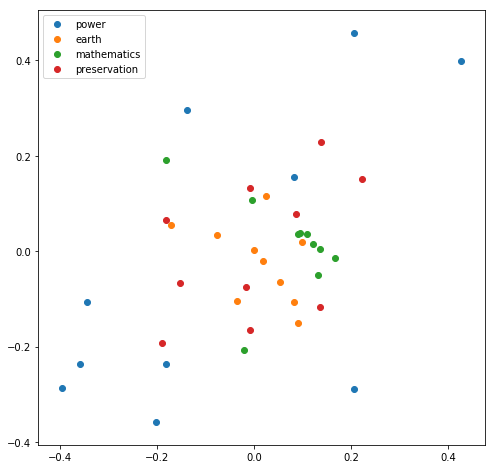

In [18]:
with torch.no_grad():
    test1 = net(one_hot(dct2.token2id['power']).cuda())
    test2 = net(one_hot(dct2.token2id['earth']).cuda())
    test3 = net(one_hot(dct2.token2id['mathematics']).cuda())
    test4 = net(one_hot(dct2.token2id['preservation']).cuda())
plt.figure(figsize=(8,8))
plt.scatter(test1.view(M,2).t().cpu().numpy()[0], test1.view(M,2).t().cpu().numpy()[1], label='power')
plt.scatter(test2.view(M,2).t().cpu().numpy()[0], test2.view(M,2).t().cpu().numpy()[1], label='earth')
plt.scatter(test3.view(M,2).t().cpu().numpy()[0], test3.view(M,2).t().cpu().numpy()[1], label='mathematics')
plt.scatter(test4.view(M,2).t().cpu().numpy()[0], test4.view(M,2).t().cpu().numpy()[1], label='preservation')
plt.legend(loc='best')
plt.savefig('plot1.eps', bbox_inches='tight')
plt.show()

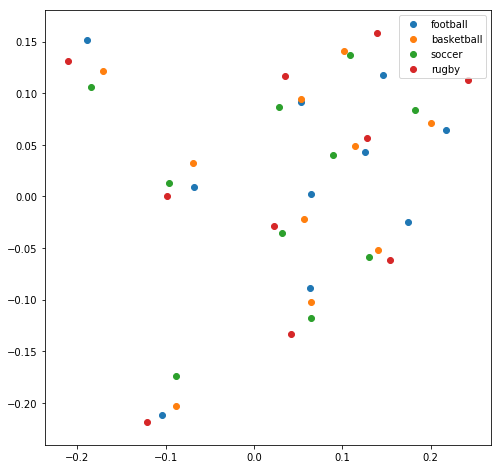

In [19]:
with torch.no_grad():
    test1 = net(one_hot(dct2.token2id['football']).cuda())
    test2 = net(one_hot(dct2.token2id['basketball']).cuda())
    test3 = net(one_hot(dct2.token2id['soccer']).cuda())
    test4 = net(one_hot(dct2.token2id['rugby']).cuda())
plt.figure(figsize=(8,8))
plt.scatter(test1.view(M,2).t().cpu().numpy()[0], test1.view(M,2).t().cpu().numpy()[1], label='football')
plt.scatter(test2.view(M,2).t().cpu().numpy()[0], test2.view(M,2).t().cpu().numpy()[1], label='basketball')
plt.scatter(test3.view(M,2).t().cpu().numpy()[0], test3.view(M,2).t().cpu().numpy()[1], label='soccer')
plt.scatter(test4.view(M,2).t().cpu().numpy()[0], test4.view(M,2).t().cpu().numpy()[1], label='rugby')
plt.legend(loc='best')
plt.savefig('plot2.eps', bbox_inches='tight')
plt.show()